In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    num_classes = 120
    # IMG_SIZE is determined by EfficientNet model choice
    IMG_SIZE = 224
    epochs = 50
    early_stopping_patience = 5
    batch_size = 64
    size= (224, 224)
    dataset_name = "stanford_dogs"

In [2]:
#Standart lib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import tensorflow_datasets as tfds


In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


In [4]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [5]:
model = EfficientNetB0(include_top=False, weights='imagenet')

In [6]:
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

# Loading data

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    CFG.dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)

In [8]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/home/ml/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
    

In [9]:
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, CFG.size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, CFG.size), label))

# Visualizing the data

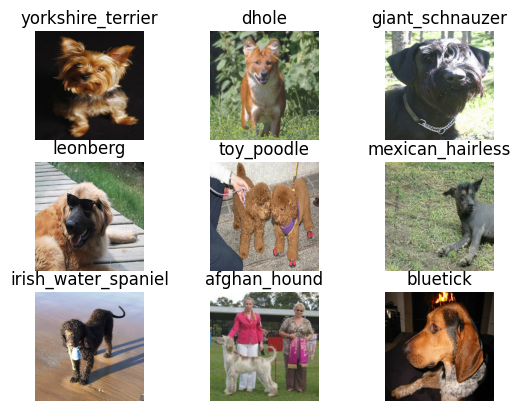

In [10]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

# Data augmentation

In [11]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.40),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
    ],
    name="img_augmentation",
)

# Visualization

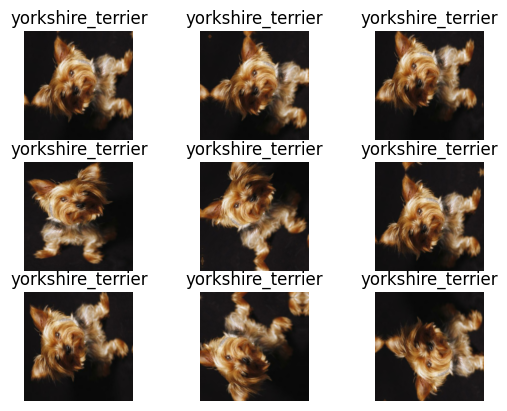

In [12]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image/255)
        plt.imshow(aug_img)
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [13]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, CFG.num_classes)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
# ds_train = ds_train.shuffle(1000, seed=CFG.SEED, reshuffle_each_iteration=True)
ds_train = ds_train.batch(batch_size=CFG.batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=CFG.batch_size, drop_remainder=True)

# Training a model from scratch

In [14]:
inputs = tf.keras.layers.Input(shape=(CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, classes=CFG.num_classes)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (224, 224, 3)            0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________


In [16]:
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                      factor=0.5,
                                                      min_delta=0.001,
                                                      patience=3,
                                                      verbose=1,
                                                      mode="auto")

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=CFG.early_stopping_patience,
    restore_best_weights=True,
    min_delta=0.001,
)

In [17]:
hist = model.fit(ds_train,
                 epochs=CFG.epochs,
                 validation_data=ds_test,
                 callbacks=[reduceLROnPlat, early_stopping])

Epoch 1/50
187/187 [==============================] - 45s 142ms/step - loss: 4.9957 - accuracy: 0.0113 - val_loss: 4.9234 - val_accuracy: 0.0139 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 26s 139ms/step - loss: 4.7119 - accuracy: 0.0194 - val_loss: 4.9414 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 26s 139ms/step - loss: 4.4957 - accuracy: 0.0302 - val_loss: 4.6364 - val_accuracy: 0.0295 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 26s 138ms/step - loss: 4.3573 - accuracy: 0.0405 - val_loss: 4.8054 - val_accuracy: 0.0196 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 26s 139ms/step - loss: 4.2593 - accuracy: 0.0462 - val_loss: 4.6497 - val_accuracy: 0.0337 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 26s 139ms/step - loss: 4.1804 - accuracy: 0.0522 - val_loss: 4.2574 - val_accuracy: 0.0512 - lr: 0.0010
Epoch 7/50
187/187 [==============================] 

Epoch 48/50
187/187 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.6018
Epoch 48: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
187/187 [==============================] - 26s 140ms/step - loss: 1.4010 - accuracy: 0.6018 - val_loss: 3.7400 - val_accuracy: 0.2450 - lr: 6.2500e-05
Epoch 49/50
187/187 [==============================] - 26s 139ms/step - loss: 1.3527 - accuracy: 0.6132 - val_loss: 3.6920 - val_accuracy: 0.2436 - lr: 3.1250e-05
Epoch 50/50
187/187 [==============================] - 26s 139ms/step - loss: 1.3482 - accuracy: 0.6125 - val_loss: 3.7408 - val_accuracy: 0.2438 - lr: 3.1250e-05


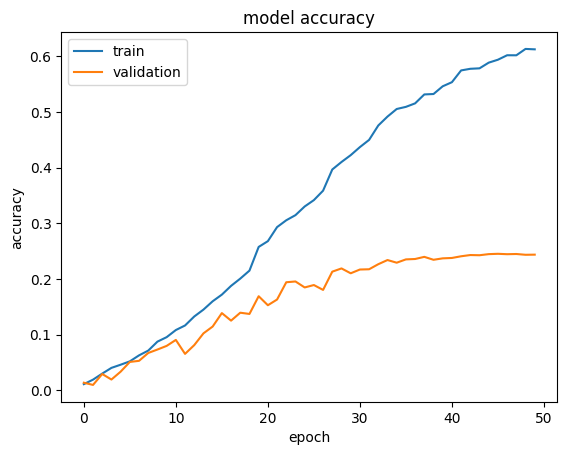

In [18]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

# Transfer learning from pre-trained weights

In [19]:
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(CFG.num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/50
187/187 [==============================] - 10s 40ms/step - loss: 3.4442 - accuracy: 0.3854 - val_loss: 0.9101 - val_accuracy: 0.7364 - lr: 0.0100
Epoch 2/50
187/187 [==============================] - 7s 39ms/step - loss: 1.7373 - accuracy: 0.5476 - val_loss: 0.7971 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 3/50
187/187 [==============================] - 7s 39ms/step - loss: 1.4303 - accuracy: 0.6000 - val_loss: 0.7618 - val_accuracy: 0.7642 - lr: 0.0100
Epoch 4/50
187/187 [==============================] - 7s 39ms/step - loss: 1.3239 - accuracy: 0.6197 - val_loss: 0.7723 - val_accuracy: 0.7662 - lr: 0.0100
Epoch 5/50
187/187 [==============================] - 7s 39ms/step - loss: 1.2928 - accuracy: 0.6327 - val_loss: 0.7561 - val_accuracy: 0.7748 - lr: 0.0100
Epoch 6/50
187/187 [==============================] - 7s 39ms/step - loss: 1.2610 - accuracy: 0.6359 - val_loss: 0.7549 - val_accuracy: 0.7761 - lr: 0.0100
Epoch 7/50
187/187 [==============================] - 7s 38ms/s

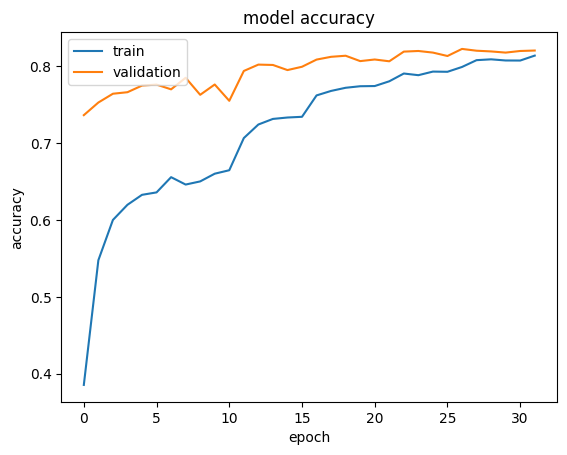

In [20]:
model = build_model(num_classes=CFG.num_classes)

# @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train,
                 epochs=CFG.epochs,
                 validation_data=ds_test,
                 callbacks=[reduceLROnPlat, early_stopping])
plot_hist(hist)

In [21]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while other layers frozen
    for layer in model.layers[-20:]:
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

Epoch 1/50
187/187 [==============================] - 11s 42ms/step - loss: 0.9359 - accuracy: 0.7230 - val_loss: 0.6402 - val_accuracy: 0.8116 - lr: 1.0000e-04
Epoch 2/50
187/187 [==============================] - 8s 40ms/step - loss: 0.7296 - accuracy: 0.7729 - val_loss: 0.6614 - val_accuracy: 0.8063 - lr: 1.0000e-04
Epoch 3/50
187/187 [==============================] - 7s 38ms/step - loss: 0.6423 - accuracy: 0.7986 - val_loss: 0.6691 - val_accuracy: 0.8077 - lr: 1.0000e-04
Epoch 4/50
186/187 [============================>.] - ETA: 0s - loss: 0.5688 - accuracy: 0.8171
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
187/187 [==============================] - 8s 40ms/step - loss: 0.5680 - accuracy: 0.8174 - val_loss: 0.6761 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 5/50
187/187 [==============================] - 8s 40ms/step - loss: 0.5237 - accuracy: 0.8349 - val_loss: 0.6722 - val_accuracy: 0.8071 - lr: 5.0000e-05
Epoch 6/50
187/187 [==================

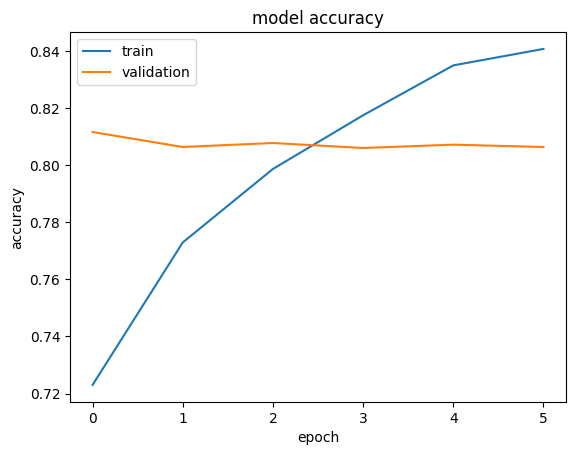

In [22]:
hist = model.fit(ds_train,
                 epochs=CFG.epochs,
                 validation_data=ds_test,
                 callbacks=[reduceLROnPlat, early_stopping])
plot_hist(hist)

In [23]:
y_pred = model.predict(ds_test.take(1))

1/1 [==============================] - 1s 537ms/step


In [24]:
# What predicted
format_label(np.argmax(y_pred[0]))

'welsh_springer_spaniel'

predicted welsh_springer_spaniel


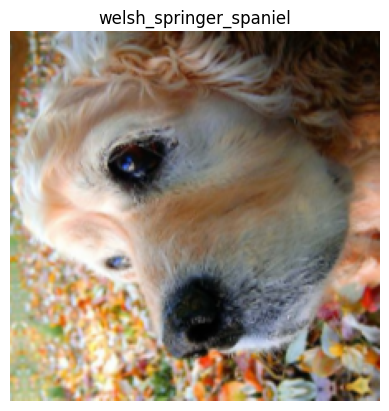

In [25]:
for batch in ds_test.take(1):
    image = batch[0]
    label = batch[1]
    aug_img = img_augmentation(image[i]/255)
    plt.imshow(aug_img)
    plt.title("{}".format(format_label(np.argmax(label[0]))))
    plt.axis("off")
    print("predicted",format_label(np.argmax(y_pred[0])))